# Benchmarking

In [1]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.QDev.QDac import QDac

In [2]:
# Initialise instruments
qdac = QDac('qdac', 'ASRL6::INSTR', update_currents=False)
dmm = Keysight_34465A('dmm', 'TCPIP0::192.168.15.106::inst0::INSTR')
dmm2 = Keysight_34465A('dmm2', 'TCPIP0::192.168.15.104::inst0::INSTR')

Connected to: Keysight Technologies 34465A (serial:MY54505388, firmware:A.02.14-02.40-02.14-00.49-02-01) in 0.12s
Connected to: Keysight Technologies 34465A (serial:MY54505281, firmware:A.02.14-02.40-02.14-00.49-02-01) in 0.08s


In [3]:
# Prepare DMM
dmm.NPLC(0.02)
dmm.trigger_source('EXT')
dmm.autorange('OFF')  # this guy is important for low times
dmm.range(1)
print('Expected time per point: {} s'.format(dmm.sample_timer_minimum()))
dmm.trigger_slope('POS')

Expected time per point: 0.001047 s


In [4]:
# Prepare QDac
qdac.ch01_sync(1)
qdac.ch01_sync_delay(0)
qdac.ch01_sync_duration(0.01)
qdac.ch01_v(0)


We ramp the QDAC from 0 V to 100 mV during the relevant time

## Single shot

In [5]:

Ns = [512, 512, 512, 1024, 1024, 1024, 2048, 2048, 2048, 4096, 4096, 4096]

Ns = [4096]

for N in Ns:

    Vrange = 0.1
    
    # Assign slope accordingly
    slope = Vrange/(N*dmm.sample_timer_minimum())
    qdac.ch01_slope(slope)
    
    # reset 
    qdac.ch01_v(0)
    time.sleep(Vrange/qdac.ch01_slope()+0.2)
    
    # Set number of points
    #N = 2048

    dmm.sample_count(N)
     
    t_start = time.time()
    dmm.data_buffer.prepare()
    dmm.data_buffer.arm()
    
    data = qc.Measure(qc.Task(qdac.ch01_v.set, Vrange), dmm.data_buffer).run()
    t_stop = time.time()
    print('Elapsed time: {:.3f} s'.format(t_stop-t_start))
    print('-'*50)

Cancelled a ramp with a ramptime of 0 s. Voltage not changed.


DataSet:
   location = 'data/2017-04-07/#083_{name}_16-29-22'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | dmm_data_buffer | data_buffer  | (4096,)
acquired at 2017-04-07 16:29:26
Elapsed time: 4.669 s
--------------------------------------------------


<IPython.core.display.Javascript object>


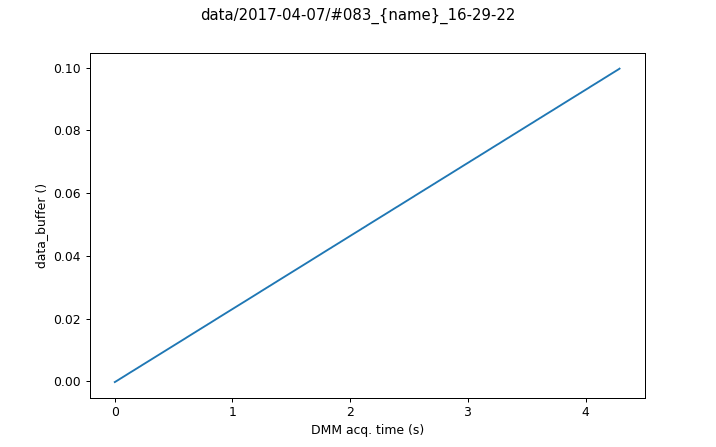

In [6]:
# Check that the acquisition captured the correct voltages

plot = qc.MatPlot()
plot.add(data.dmm_data_buffer)

## 2D stuff

In [23]:
slope = 0.1

N = 2048
dmm.sample_count(N)
tpp = dmm.sample_timer_minimum()

dmm.data_buffer.prepare()

rearm_dmm = qc.Task(dmm.data_buffer.arm)
chan_reset_1 = qc.Task(qdac.ch01_slope, 'Inf')
chan_reset_2 = qc.Task(qdac.ch01_v, 0)
chan_reset_3 = qc.Task(qdac.ch01_slope, slope)
chan_reset_4 = qc.Task(qdac.ch01_sync, 1)
chan_go = qc.Task(qdac.ch01_v, N*tpp*slope)  # make a full ramp
print('Fast axis sweeps from {} V to {} V'.format(0, N*tpp*slope))

Fast axis sweeps from 0 V to 0.2144256 V


In [24]:
steps = 50
loop = qc.Loop(qdac.ch02_v.sweep(0, 1, num=steps), delay=0.01).each(rearm_dmm,
                                                              chan_reset_1,
                                                              chan_reset_2,
                                                              chan_reset_3, 
                                                              chan_reset_4,
                                                              chan_go,
                                                              dmm.data_buffer)
data = loop.get_data_set(name='testsweep')
plot = qc.QtPlot()
plot.add(data.dmm_data_buffer)

start_time = time.time()
_ = loop.with_bg_task(plot.update, plot.save).run()
stop_time = time.time()
del_t = stop_time - start_time
print('Performed 2D sweep of {} steps on slow axis and {} points on fast axis in {:.3f} seconds'.format(steps,
                                                                                                        N,
                                                                                                        del_t))

DataSet:
   location = 'data/2017-04-07/#082_testsweep_16-24-24'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | qdac_ch02_v_set | ch02_v       | (50,)
   Measured | dmm_data_buffer | data_buffer  | (50, 2048)
started at 2017-04-07 16:26:36
Performed 2D sweep of 50 steps on slow axis and 2048 points on fast axis in 130.994 seconds


## 2 DMMs 2D sweeps

In [7]:
# Prepare DMMs
dmm.NPLC(0.02)
dmm.trigger_source('EXT')
dmm.autorange('OFF')  # this guy is important for low times
dmm.range(1)
dmm.trigger_slope('POS')

dmm2.NPLC(0.02)
dmm2.trigger_source('EXT')
dmm2.autorange('OFF')  # this guy is important for low times
dmm2.range(1)
dmm2.trigger_slope('POS')

In [13]:
# make tasks for the loop

slope = 0.1

N = 2048
dmm.sample_count(N)
dmm2.sample_count(N)
tpp = dmm.sample_timer_minimum()

dmm.data_buffer.prepare()
dmm2.data_buffer.prepare()

rearm_dmm = qc.Task(dmm.data_buffer.arm)
rearm_dmm2 = qc.Task(dmm2.data_buffer.arm)
chan_reset_1 = qc.Task(qdac.ch01_slope, 'Inf')
chan_reset_2 = qc.Task(qdac.ch01_v, 0)
chan_reset_3 = qc.Task(qdac.ch01_slope, slope)
chan_reset_4 = qc.Task(qdac.ch01_sync, 1)
chan_go = qc.Task(qdac.ch01_v, N*tpp*slope)  # make a full ramp
print('Fast axis sweeps from {} V to {} V'.format(0, N*tpp*slope))

Fast axis sweeps from 0 V to 0.2144256 V


In [17]:
steps = 50
loop = qc.Loop(qdac.ch02_v.sweep(0, 1, num=steps), delay=0.01).each(rearm_dmm,
                                                                    rearm_dmm2,
                                                                    chan_reset_1,
                                                                    chan_reset_2,
                                                                    chan_reset_3, 
                                                                    chan_reset_4,
                                                                    chan_go,
                                                                    dmm.data_buffer,
                                                                    dmm2.data_buffer)
data = loop.get_data_set(name='testsweep')
plot = qc.QtPlot()
plot.add(data.dmm_data_buffer, subplot=1)
plot.add(data.dmm2_data_buffer, subplot=2)

start_time = time.time()
_ = loop.with_bg_task(plot.update, plot.save).run()
stop_time = time.time()
del_t = stop_time - start_time
print('-'*50)
print('Acquiring from 2 DMMs')
print('Performed 2D sweep of {} steps on slow axis and {} points on fast axis in {:.3f} seconds'.format(steps,
                                                                                                        N,
                                                                                                        del_t))

DataSet:
   location = 'data/2017-04-07/#090_testsweep_16-53-41'
   <Type>   | <array_id>       | <array.name> | <array.shape>
   Setpoint | qdac_ch02_v_set  | ch02_v       | (50,)
   Measured | dmm_data_buffer  | data_buffer  | (50, 2048)
   Measured | dmm2_data_buffer | data_buffer  | (50, 2048)
started at 2017-04-07 16:56:00
--------------------------------------------------
Acquiring from 2 DMMs
Performed 2D sweep of 50 steps on slow axis and 2048 points on fast axis in 138.363 seconds
